/home/adityab/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/50 - Train Loss: 0.0589 - Val Loss: 0.0382
Epoch 2/50 - Train Loss: 0.0358 - Val Loss: 0.0362
Epoch 3/50 - Train Loss: 0.0315 - Val Loss: 0.0396
Epoch 4/50 - Train Loss: 0.0302 - Val Loss: 0.0314
Epoch 5/50 - Train Loss: 0.0283 - Val Loss: 0.0332
Epoch 6/50 - Train Loss: 0.0280 - Val Loss: 0.0326
Epoch 7/50 - Train Loss: 0.0276 - Val Loss: 0.0331
Epoch 8/50 - Train Loss: 0.0260 - Val Loss: 0.0328
Epoch 9/50 - Train Loss: 0.0259 - Val Loss: 0.0297
Epoch 10/50 - Train Loss: 0.0255 - Val Loss: 0.0320
Epoch 11/50 - Train Loss: 0.0267 - Val Loss: 0.0320
Epoch 12/50 - Train Loss: 0.0243 - Val Loss: 0.0395
Epoch 13/50 - Train Loss: 0.0255 - Val Loss: 0.0327
Epoch 14/50 - Train Loss: 0.0250 - Val Loss: 0.0278
Epoch 15/50 - Train Loss: 0.0234 - Val Loss: 0.0308
Epoch 16/50 - Train Loss: 0.0233 - Val Loss: 0.0298
Epoch 17/50 - Train Loss: 0.0231 - Val Loss: 0.0316
Epoch 18/50 - Train Loss: 0.0228 - Val Loss: 0.0301
Epoch 19/50 - Train Loss: 0.0246 - Val Loss: 0.0310
Epoch 20/50 - Train L

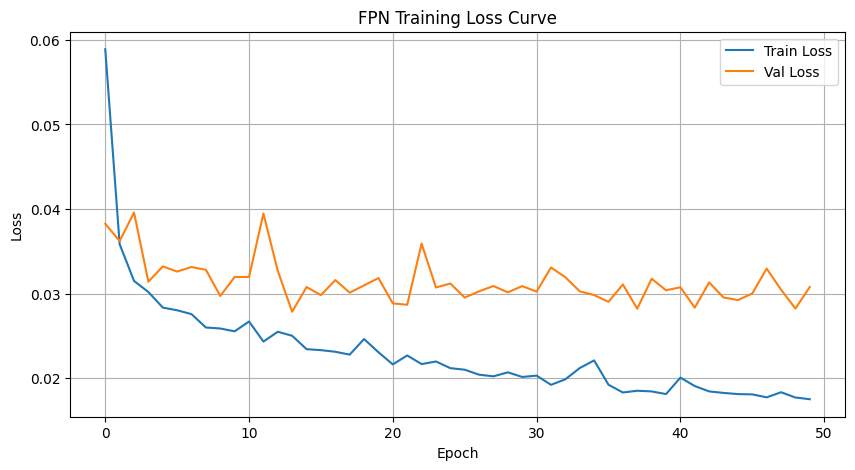

In [1]:
import os
import json, random
import torch
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt



def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For CUDA deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# --- Custom Dataset ---
class CrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') and os.path.exists(os.path.join(root_dir, f.replace('.jpg', '.json')))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        json_path = img_path.replace('.jpg', '.json')
        
        image = Image.open(img_path).convert("RGB")
        with open(json_path, 'r') as f:
            annotation = json.load(f)
        
        mask = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)
        for shape in annotation['shapes']:
            points = np.array(shape['points'], dtype=np.int32)
            cv2.fillPoly(mask, [points], 255)
        mask = Image.fromarray(mask)

        if self.transform:
            image, mask = self.transform(image, mask)
        
        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

# --- Paired Transform ---
class PairedTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
        ])
    def __call__(self, image, mask):
        seed = np.random.randint(2147483647)
        random_state = torch.manual_seed(seed)
        image = self.transform(image)
        torch.manual_seed(seed)
        mask = self.transform(mask)
        return image, mask

set_seed(42)

# --- Dataset and Dataloader Setup ---
root_dir = "/home/adityab/ADRL/final/Segmented major_crack_latest"  # UPDATE THIS
transform = PairedTransform()
dataset = CrackDataset(root_dir, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False)


# --- Model, Loss, Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.FPN(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# --- Training Loop ---
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

# --- Plotting ---
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("FPN Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


Precision: 0.8320809798459122
Recall: 0.7813385125120276
F1 Score: 0.8059118142079835
Mean Dice Score: 0.7955963630727269
Mean IoU Score: 0.6711198748114274


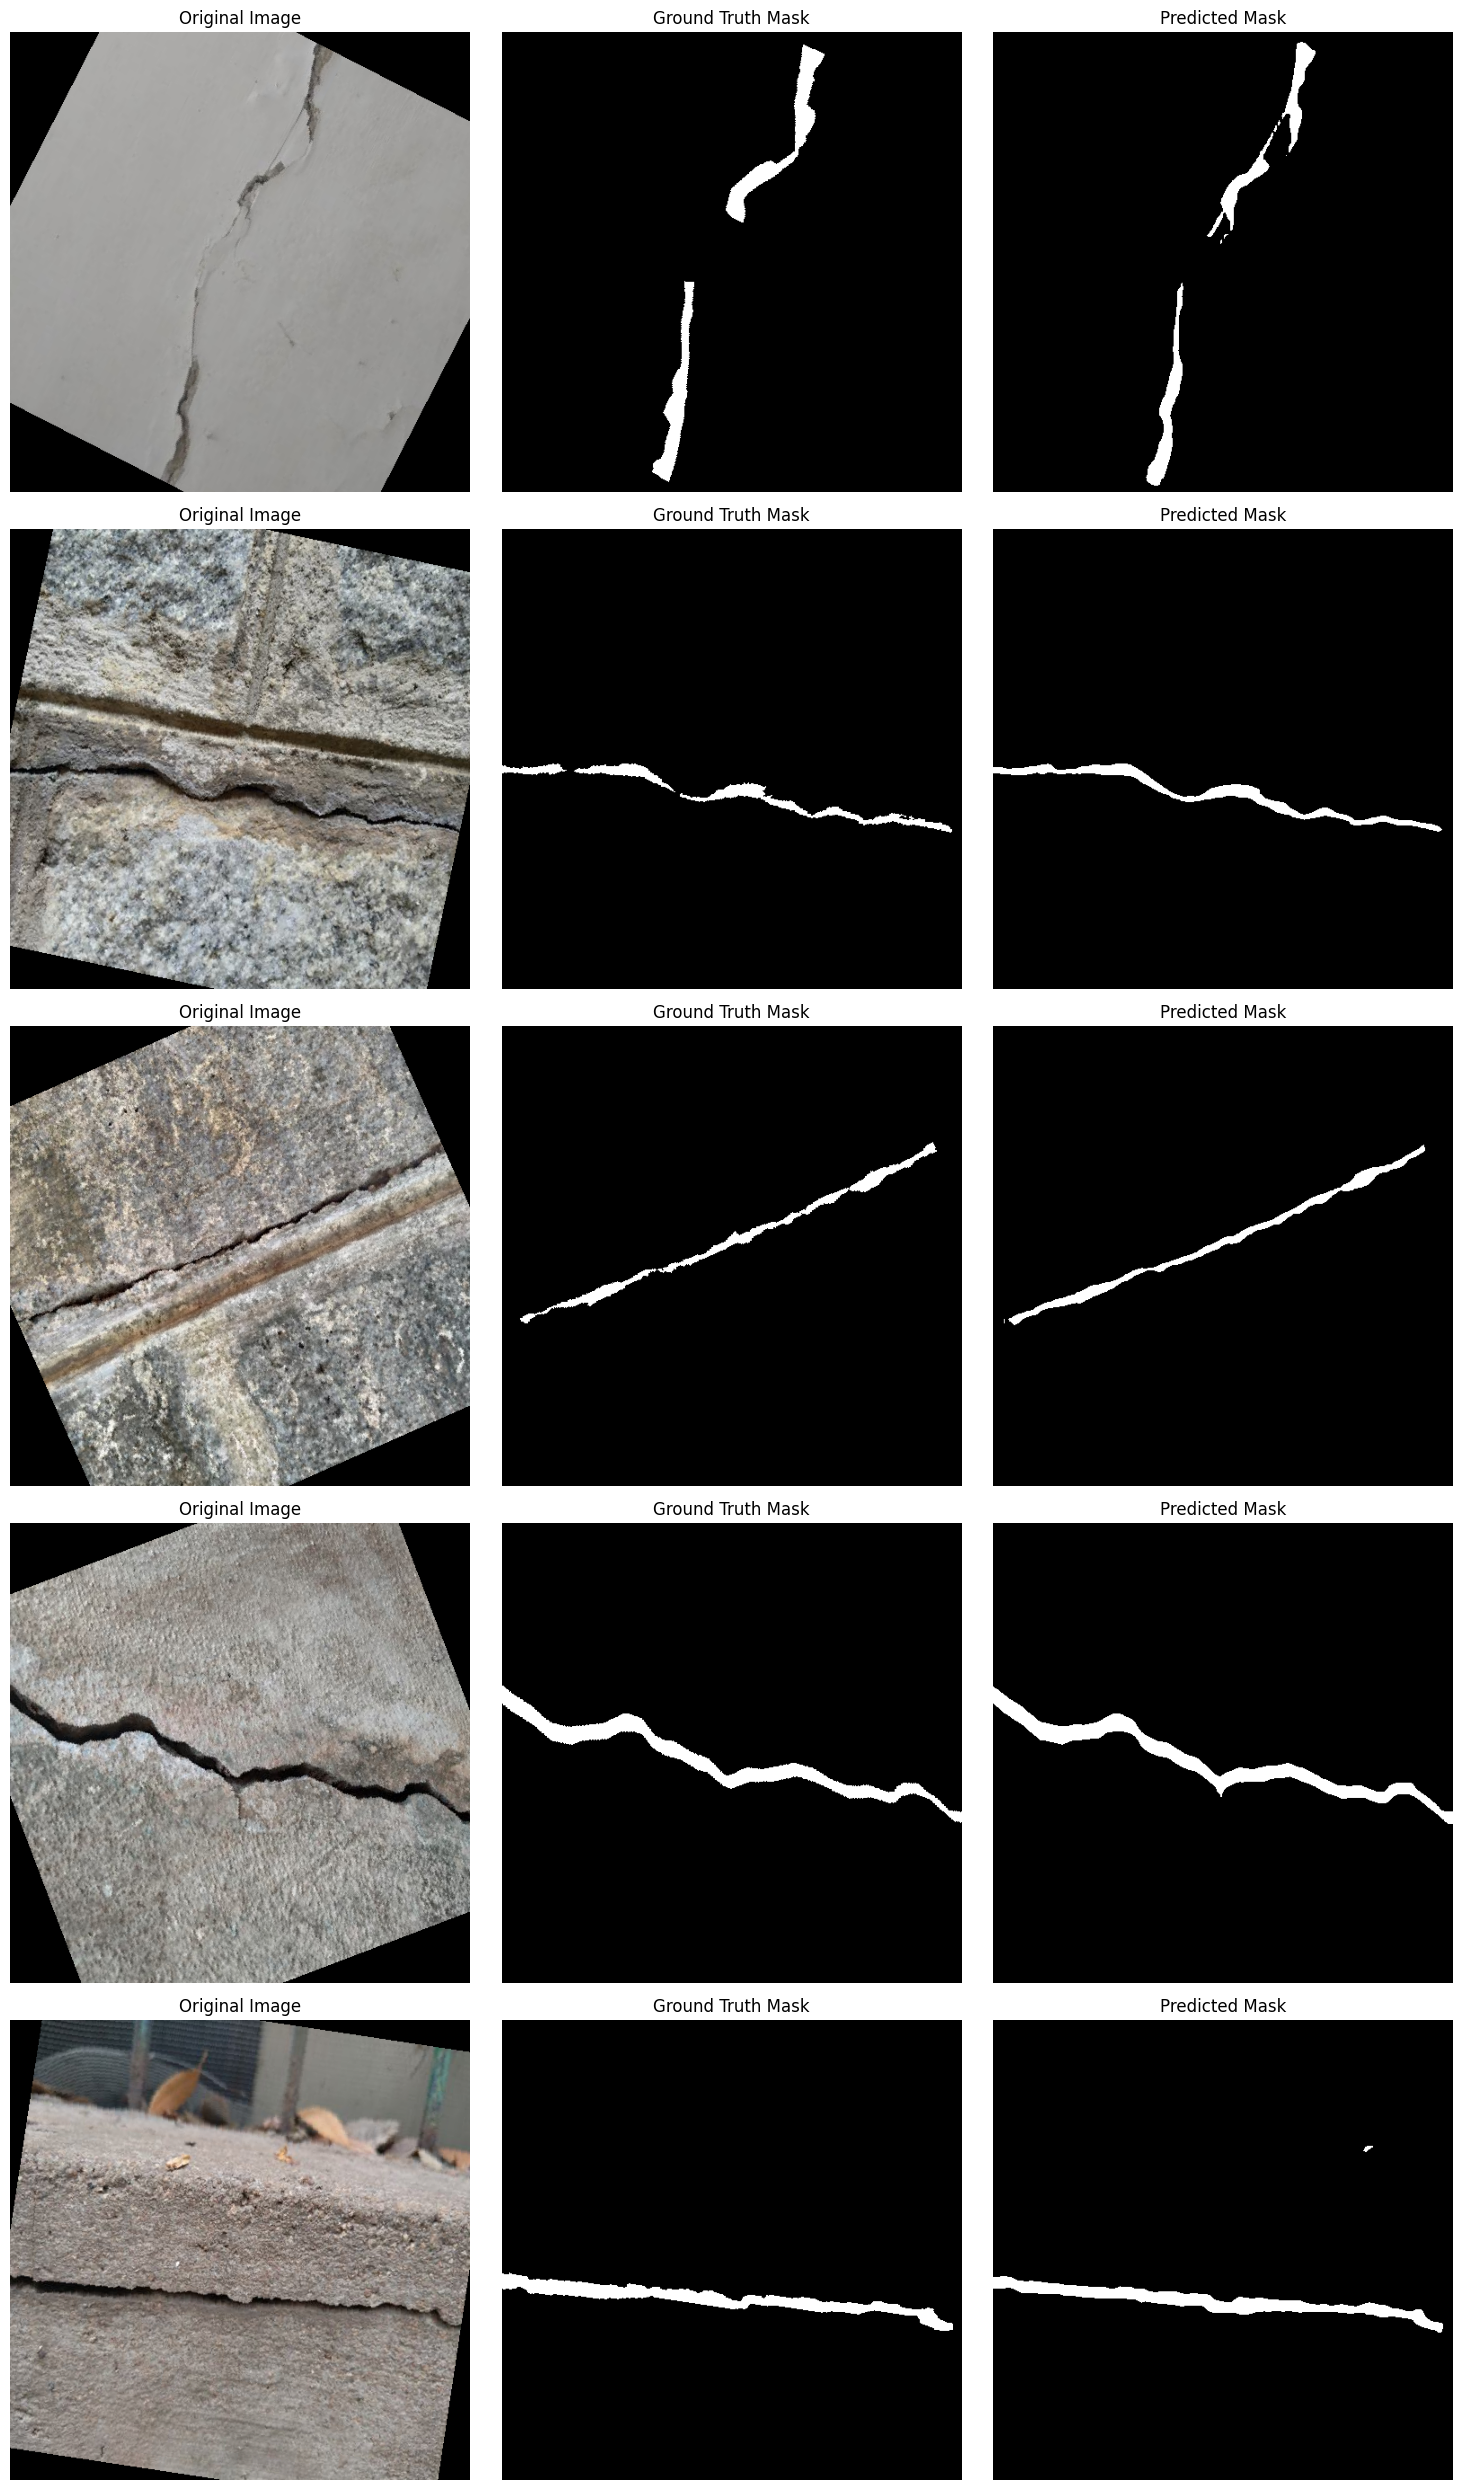

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import random

# Helper metric functions
def dice_coefficient(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# Thresholding function
def binarize(tensor, threshold=0.5):
    return (tensor > threshold).float()

# Evaluate the model on test set
def evaluate_model(model, test_loader, device='cuda', threshold=0.5, num_images_to_display=5):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []
    dice_scores = []
    iou_scores = []

    display_samples = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))
            preds = binarize(outputs, threshold)

            # Save for metrics
            all_preds.extend(preds.cpu().numpy().astype(np.uint8).flatten())
            all_targets.extend(masks.cpu().numpy().astype(np.uint8).flatten())

            dice_scores.append(dice_coefficient(preds, masks).item())
            iou_scores.append(iou_score(preds, masks).item())

            if len(display_samples) < num_images_to_display:
                display_samples.append((images.cpu(), masks.cpu(), preds.cpu()))

    # Classification metrics
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Mean Dice Score:", mean_dice)
    print("Mean IoU Score:", mean_iou)

    # Visualize 5 test samples
    fig, axs = plt.subplots(num_images_to_display, 3, figsize=(15, 5 * num_images_to_display))
    if num_images_to_display == 1:
        axs = [axs]

    for idx, (image, mask, pred) in enumerate(display_samples):
        img = np.transpose(image[0].numpy(), (1, 2, 0))
        axs[idx][0].imshow(img)
        axs[idx][0].set_title("Original Image")
        axs[idx][0].axis("off")

        axs[idx][1].imshow(mask[0][0].numpy(), cmap='gray')
        axs[idx][1].set_title("Ground Truth Mask")
        axs[idx][1].axis("off")

        axs[idx][2].imshow(pred[0][0].numpy(), cmap='gray')
        axs[idx][2].set_title("Predicted Mask")
        axs[idx][2].axis("off")

    plt.tight_layout()
    plt.show()

test_loader = DataLoader(test_ds, batch_size=2, shuffle=False)
# Run evaluation
evaluate_model(model=model, test_loader=test_loader, device=device, threshold=0.5, num_images_to_display=5)

